In [1]:
# 必要なライブラリのインポート
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# データセットの準備
BATCH_SIZE = 100

trainval_data = MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
train_size = int(len(trainval_data) * 0.8)
val_size = len(trainval_data) - train_size
train_data, val_data = torch.utils.data.random_split(trainval_data, [train_size, val_size])

train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(dataset=val_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

print(f"Train data size: {len(train_data)}")
print(f"Validation data size: {len(val_data)}")


Train data size: 48000
Validation data size: 12000


In [3]:
# VAEのモデル定義
class Encoder(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 300)
        self.fc2 = nn.Linear(300, 100)
        self.fc_ave = nn.Linear(100, z_dim)
        self.fc_log_var = nn.Linear(100, z_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        ave = self.fc_ave(x)
        log_var = self.fc_log_var(x)
        eps = torch.randn_like(ave)
        z = ave + torch.exp(log_var / 2) * eps  # 再パラメータ化トリック
        return z, ave, log_var

class Decoder(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.fc1 = nn.Linear(z_dim, 100)
        self.fc2 = nn.Linear(100, 300)
        self.fc3 = nn.Linear(300, 28 * 28)
        self.relu = nn.ReLU()

    def forward(self, z):
        x = self.relu(self.fc1(z))
        x = self.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # MNISTの画像範囲に合わせてシグモイド
        return x

class VAE(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)

    def forward(self, x):
        z, ave, log_var = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, z, ave, log_var


In [4]:
# 損失関数
def vae_loss(reconstructed, original, ave, log_var):
    bce_loss = F.binary_cross_entropy(reconstructed, original, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + log_var - ave**2 - log_var.exp())
    return bce_loss + kl_loss

# モデルとオプティマイザの設定
z_dim = 2
vae = VAE(z_dim).to('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)

# トレーニングループ
num_epochs = 10
for epoch in range(num_epochs):
    vae.train()
    for batch in train_loader:
        images, _ = batch
        images = images.view(-1, 28 * 28).to('cuda' if torch.cuda.is_available() else 'cpu')
        reconstructed, z, ave, log_var = vae(images)
        loss = vae_loss(reconstructed, images, ave, log_var)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")


Epoch 1/10, Loss: 17295.2480
Epoch 2/10, Loss: 16097.1709
Epoch 3/10, Loss: 14914.5645
Epoch 4/10, Loss: 15346.3369
Epoch 5/10, Loss: 15402.8467
Epoch 6/10, Loss: 15813.7480
Epoch 7/10, Loss: 15067.1221
Epoch 8/10, Loss: 14971.0615
Epoch 9/10, Loss: 15700.4541
Epoch 10/10, Loss: 15217.0146


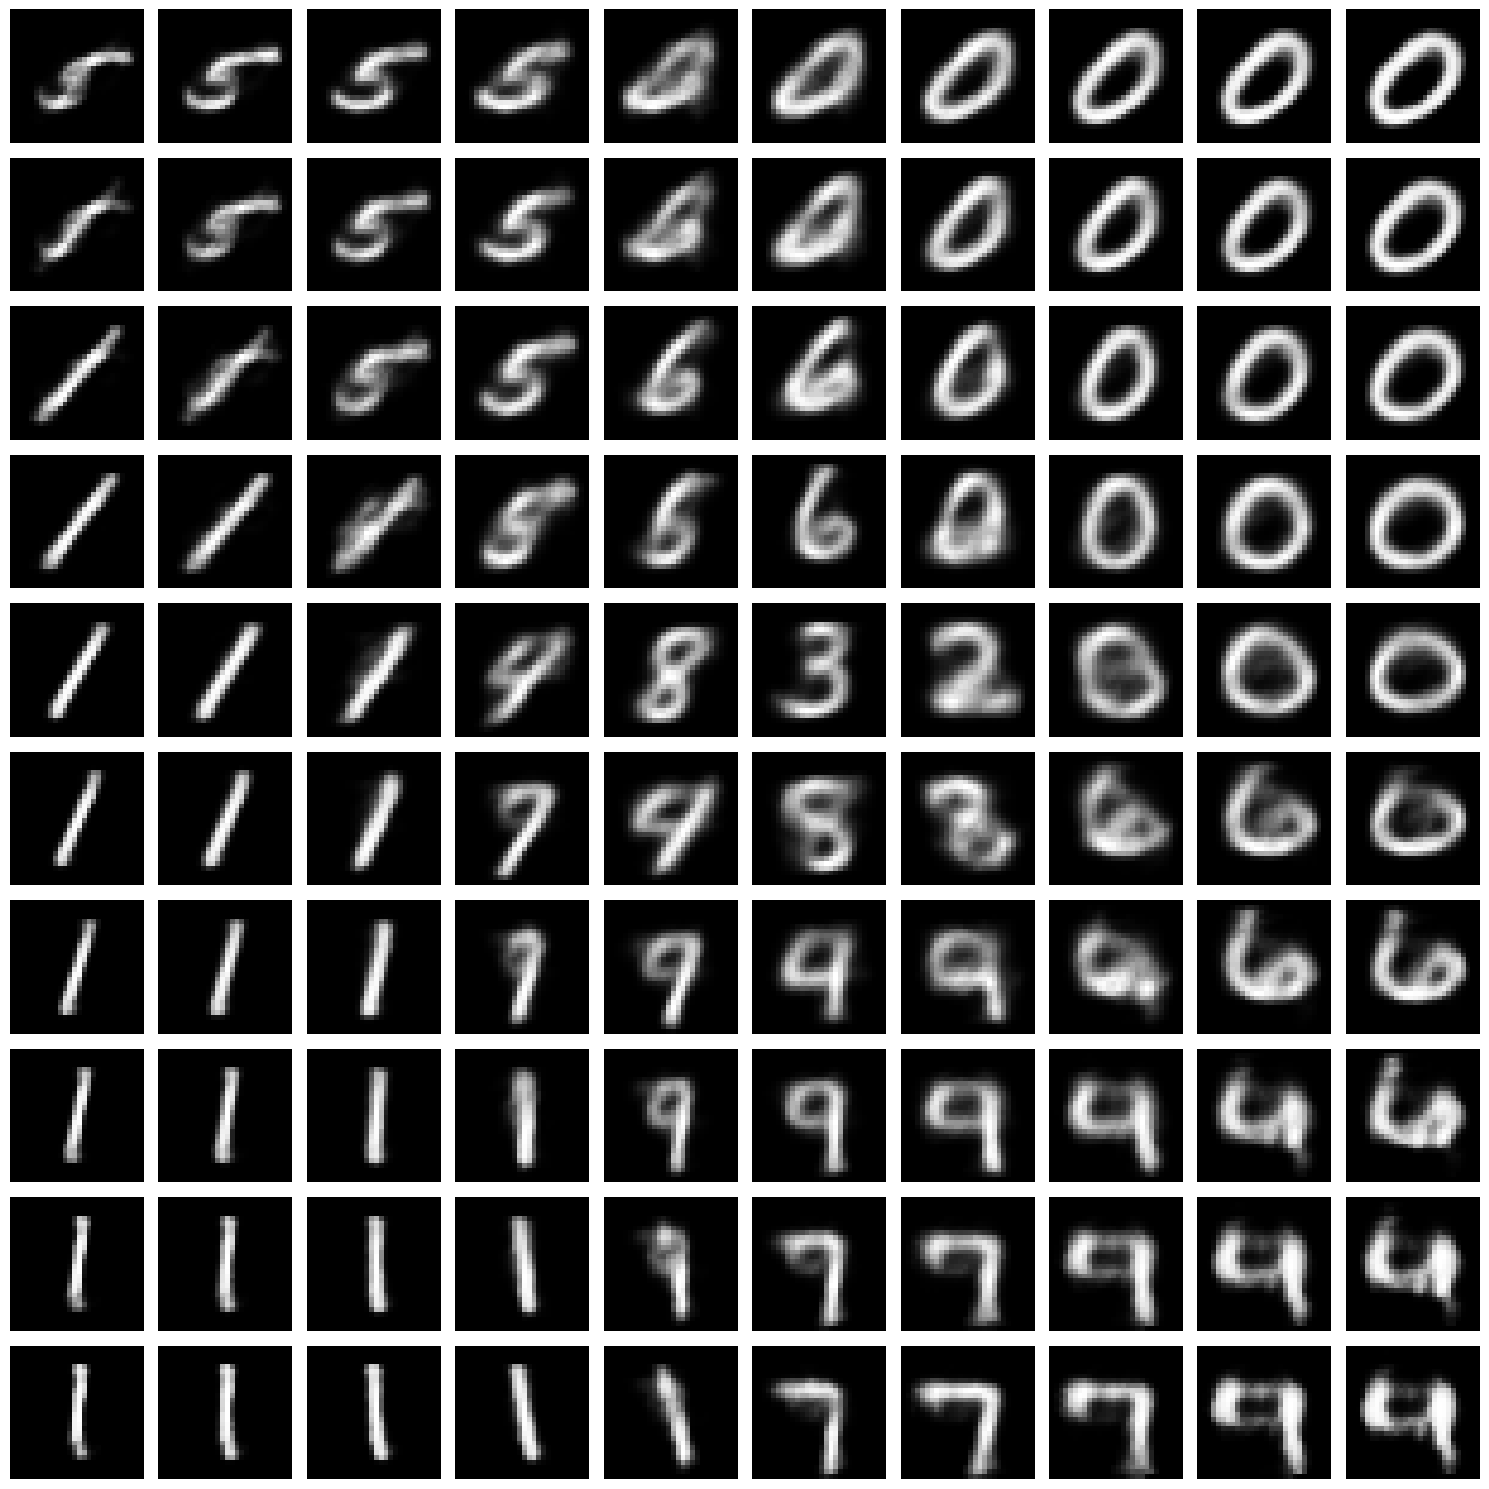

In [5]:
# 潜在空間から画像を生成
vae.eval()
sample_range = torch.linspace(-3, 3, 10)
fig, axes = plt.subplots(10, 10, figsize=(15, 15))

for i, x in enumerate(sample_range):
    for j, y in enumerate(sample_range):
        z_sample = torch.tensor([[x.item(), y.item()]]).to('cuda' if torch.cuda.is_available() else 'cpu')
        with torch.no_grad():
            generated = vae.decoder(z_sample)
        image = generated.view(28, 28).cpu().numpy()
        axes[i, j].imshow(image, cmap='gray')
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()


In [6]:
# 簡易的なMNIST分類モデル
class MNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

classifier = MNISTClassifier().to('cuda' if torch.cuda.is_available() else 'cpu')
optimizer_cls = torch.optim.Adam(classifier.parameters(), lr=0.001)
criterion_cls = nn.CrossEntropyLoss()

# 学習ループ
for epoch in range(5):
    classifier.train()
    for images, labels in train_loader:
        images = images.view(-1, 28 * 28).to('cuda' if torch.cuda.is_available() else 'cpu')
        labels = labels.to('cuda' if torch.cuda.is_available() else 'cpu')
        outputs = classifier(images)
        loss = criterion_cls(outputs, labels)

        optimizer_cls.zero_grad()
        loss.backward()
        optimizer_cls.step()

    print(f"Epoch {epoch+1}/5, Loss: {loss.item():.4f}")


Epoch 1/5, Loss: 0.1249
Epoch 2/5, Loss: 0.1260
Epoch 3/5, Loss: 0.0772
Epoch 4/5, Loss: 0.0565
Epoch 5/5, Loss: 0.0231


In [9]:
# 潜在空間から生成された画像で分類精度を計算
correct = 0
total = 0
vae.eval()
classifier.eval()

# 潜在空間のサンプル点
sample_range = torch.linspace(-3, 3, 10)

# 真のラベルを保持するリスト
true_labels = []
predicted_labels = []

for i, (images, labels) in enumerate(val_loader):
    # データをデバイスに転送
    images = images.view(-1, 28 * 28).to('cuda' if torch.cuda.is_available() else 'cpu')
    labels = labels.to('cuda' if torch.cuda.is_available() else 'cpu')

    # VAEで潜在空間に射影
    with torch.no_grad():
        _, z, _, _ = vae(images)

    # 潜在空間から生成画像を取得し、分類器で分類
    for j in range(z.size(0)):
        z_sample = z[j].unsqueeze(0)  # サンプルごとに潜在変数を取り出す
        with torch.no_grad():
            generated = vae.decoder(z_sample).view(-1, 28 * 28)
            logits = classifier(generated)
            predicted_label = torch.argmax(logits, dim=1)

        # 真のラベルと予測ラベルを記録
        true_labels.append(labels[j].item())
        predicted_labels.append(predicted_label.item())

        # 精度計算用
        correct += (predicted_label == labels[j]).item()
        total += 1

# 精度を表示
accuracy = correct / total * 100
print(f"Generated Image Classification Accuracy: {accuracy:.2f}%")


Generated Image Classification Accuracy: 71.47%
